In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from numpy.random import normal
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth



In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)
    

In [3]:
setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-19 12:46:38.237569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#load the image arrays, Size: (ngals, 64, 64), (2, ngals, 64, 64) respectively 

#Blends and components arrays are both noiseless

#Noise is then added to the blends which the network trains on

#Noiseless blends are used for the metrics 

blends = np.load("nc_blends.npy")
components = np.load("nc_components.npy")


In [5]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)

In [6]:
blends.shape, components.shape

((120000, 64, 64), (2, 120000, 64, 64))

In [7]:
np.mean(blends), np.mean(components)

(0.30960333502264886, 0.1548016675113234)

In [8]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]
test_blends_noiseless = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)

train_components = np.concatenate((a, b, c, d), axis = 1)


In [9]:
#Add noise to the training blends 

train_blends = add_noise(train_blends)

#Making a test_blends with noise to display for the summary plots 

#The noiseless test_blends are used for the metrics 

test_blends = add_noise(test_blends)

In [10]:
#Now normalise based on maximum value of the arrays

norm_max = np.max([ np.max(train_blends), np.max(test_blends), np.max(train_components), np.max(test_components), np.max(test_blends_noiseless)])

train_blends /= norm_max
test_blends /= norm_max
test_blends_noiseless /= norm_max
train_components /= norm_max
test_components /= norm_max

In [11]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends), np.amax(test_blends_noiseless), np.amin(test_blends_noiseless)

(1.0,
 -0.012382026769836022,
 0.9244290761893011,
 -0.011930068610520757,
 0.9254710614372668,
 2.4922726006032427e-20)

In [12]:
np.amax(test_components), np.amin(test_components), np.amax(train_components), np.amin(train_components)

(0.6063736278190439,
 2.10041103510263e-47,
 0.6180540343958576,
 5.843694696882484e-38)

In [13]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')

test_blends_noiseless = test_blends_noiseless.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')




In [14]:
batch_size = 32
latent_dimensions = 32

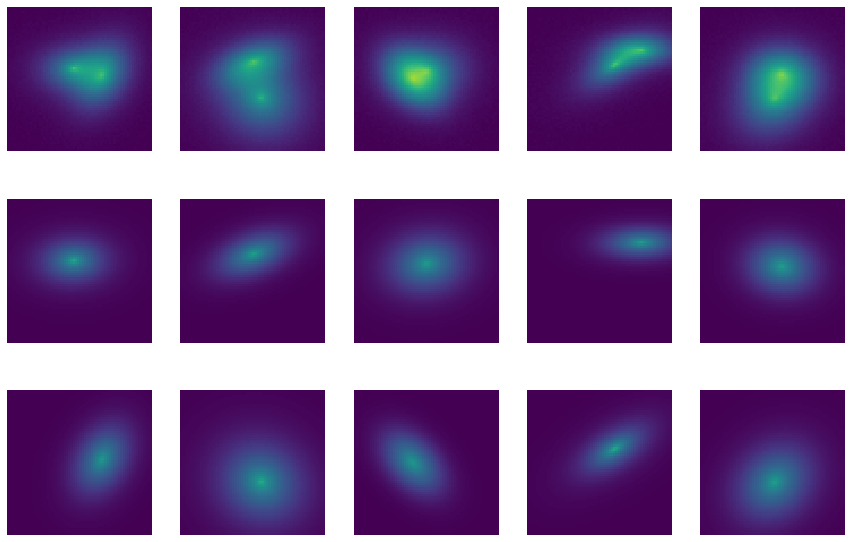

In [15]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[0, i].axis('off')
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[1, i].axis('off')
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[2, i].axis('off')

In [16]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu', strides = 2, padding='same')(x)
    x=Conv2D(64,3,activation='relu', strides = 2, padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [17]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu', strides = 2 ,padding='same')(x)
    x=Conv2DTranspose(32,3,activation='relu', strides = 2 ,padding='same')(x)
    return x

In [18]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [19]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [20]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [21]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [22]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 64)     0           ['dense_2[0][0]']                
                                                                                            

In [23]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [24]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           281024      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                            

In [25]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0], train_components[1]]
test_together = [test_blends, test_components[0], test_components[1], test_blends_noiseless]

vae.compile(optimizer=Adam())

In [26]:
val_split_ratio = 0.2
print(val_split_ratio * train_ngals)

19200.0


In [27]:
history=vae.fit(train_together, verbose = 1, epochs = 100, batch_size = batch_size, validation_split = val_split_ratio)

Epoch 1/100
2400/2400 [==============================] - 39s 14ms/step - loss: 2.6225 - mse_loss: 2.3955 - kl_loss: 0.2270 - val_loss: 1.6419 - val_mse_loss: 1.4067 - val_kl_loss: 0.2352
Epoch 2/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.4436 - mse_loss: 1.2063 - kl_loss: 0.2373 - val_loss: 1.2986 - val_mse_loss: 1.0616 - val_kl_loss: 0.2370
Epoch 3/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.2396 - mse_loss: 1.0033 - kl_loss: 0.2363 - val_loss: 1.1580 - val_mse_loss: 0.9174 - val_kl_loss: 0.2405
Epoch 4/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.1175 - mse_loss: 0.8821 - kl_loss: 0.2354 - val_loss: 1.1655 - val_mse_loss: 0.9215 - val_kl_loss: 0.2441
Epoch 5/100
2400/2400 [==============================] - 31s 13ms/step - loss: 1.0449 - mse_loss: 0.8115 - kl_loss: 0.2334 - val_loss: 1.1066 - val_mse_loss: 0.8845 - val_kl_loss: 0.2221
Epoch 6/100
2400/2400 [==============================] - 31s 13ms

In [28]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

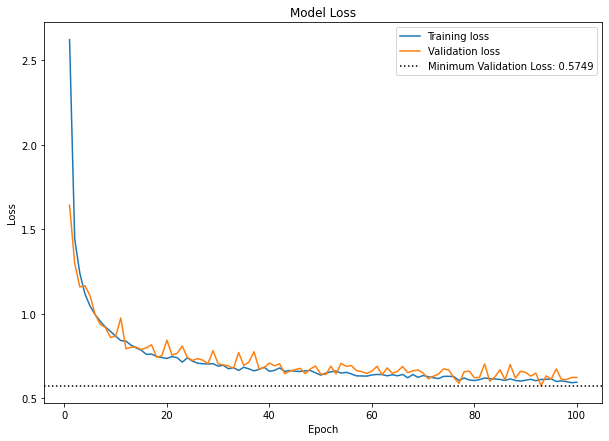

In [29]:
histplot(history)

In [30]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    noisy_input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    noiseless_input_img = inputs[3][idx]
    z = encode.predict(noisy_input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(7, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(noisy_input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('In Blend')
        ax[0, i].axis('off')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('In Comp 1')
        ax[1, i].axis('off')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[2, i].set_title('In Comp 2')
        ax[2, i].axis('off')
        ax[3, i].imshow(output_img1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[3, i].set_title(f'Re Comp 1 - SSIM:{ssim(comp1[i], output_img1[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[3, i].axis('off')
        ax[4, i].imshow(output_img2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[4, i].set_title(f'Re Comp 2 - SSIM: {ssim(comp2[i], output_img2[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[4, i].axis('off')
        ax[5, i].imshow((output_img1[i] + output_img2[i]) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[5, i].set_title(f'Re Blend - SSIM: {ssim(noiseless_input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[5, i].axis('off')
        ax[6, i].imshow(abs(noiseless_input_img[i] -(output_img1[i] + output_img2[i])) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[6, i].set_title('Blend Difference')
        ax[6, i].axis('off')
        plt.tight_layout()
    return idx

[ 6414 13523  8374  5256  4405]


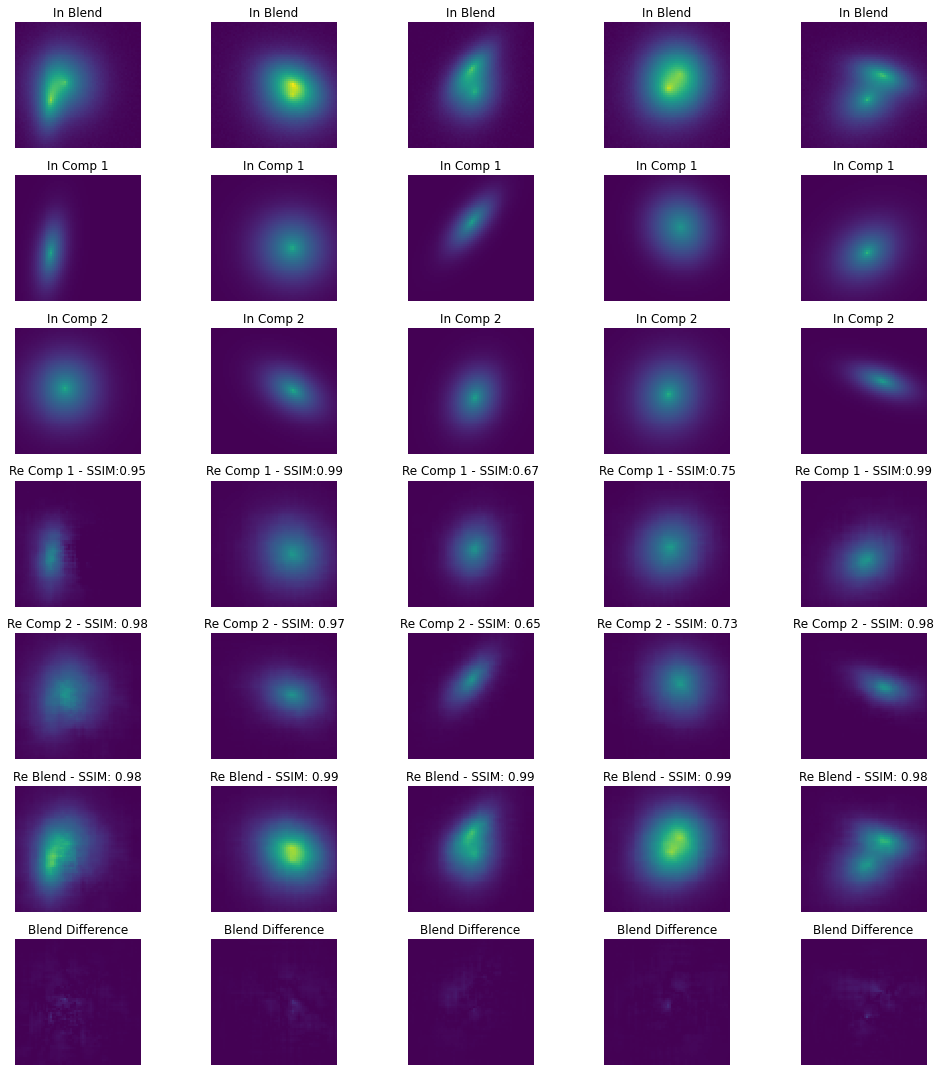

In [31]:
n=5
chosen=summary_plot(n,test_together,decode)

In [32]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    noisy_input_img = inputs[0]
    comp1 = inputs[1]
    comp2 = inputs[2]
    noiseless_input_img = inputs[3]
    z = encode.predict(noisy_input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False)
        ssim_comp2[i] = ssim(comp2[i], output_img2[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False)
        ssim_blends[i] = ssim(noiseless_input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2, gaussian_weights = True, use_sample_covarience = False)
    
    ssim_values = np.array([ssim_comp1, ssim_comp2, ssim_blends])
    
    return ssim_values 
        
        
        

    
    

In [33]:
ssim_values = calc_ssim(test_together, decode)

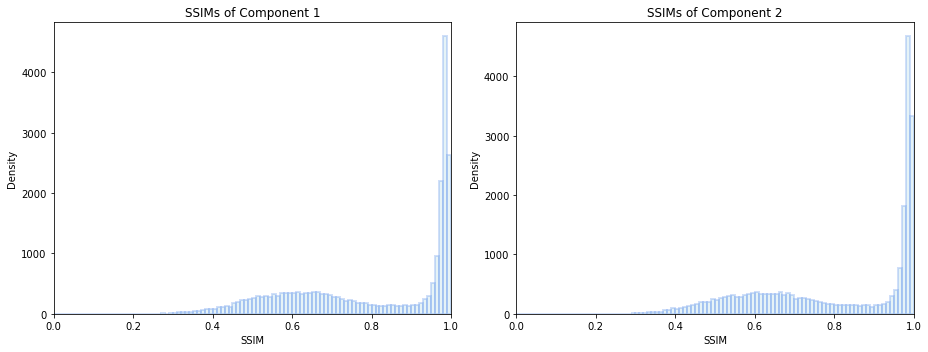

In [34]:
#Plot violinplots of the SSIM

n_of_bins = 100
bins = np.linspace(0,1,n_of_bins+1)

c = 'lightblue'
outline = 'cornflowerblue'


fig, ax = plt.subplots(1, 2, figsize = (13,5))


vp1 = ax[0].hist(ssim_values[0], bins, color = c, ec = outline, alpha = 0.3, lw = 2)

ax[0].set_title('SSIMs of Component 1')
ax[0].set_xlabel('SSIM')
ax[0].set_ylabel('Density')

 

vp2 = ax[1].hist(ssim_values[1], bins,  color = c, ec = outline, alpha = 0.3, lw = 2)

ax[1].set_title('SSIMs of Component 2')  
ax[1].set_xlabel('SSIM')
ax[1].set_ylabel('Density')
  
ax[0].set_xlim(0, 1) 
ax[1].set_xlim(0, 1) 
plt.tight_layout()

plt.show()

In [35]:
mean_ssim_comp1 = np.mean(ssim_values[0])
median_ssim_comp1 = np.median(ssim_values[0])
mean_ssim_comp2 = np.mean(ssim_values[1])
median_ssim_comp2 = np.median(ssim_values[1])
mean_ssim_blends = np.mean(ssim_values[2])
median_ssim_blends = np.median(ssim_values[2])

In [36]:
print(f' Mean SSIMs: Component 1: {mean_ssim_comp1:.4f}, Component 2: {mean_ssim_comp2:.4f}, Blends: {mean_ssim_blends:.4f}')

print(f' Median SSIMs: Component 1: {median_ssim_comp1:.4f}, Component 2: {median_ssim_comp2:.4f}, Blends: {median_ssim_blends:.4f}')


 Mean SSIMs: Component 1: 0.8015, Component 2: 0.8051, Blends: 0.9855
 Median SSIMs: Component 1: 0.8931, Component 2: 0.8980, Blends: 0.9886


In [37]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    flux_in_comp2 = np.zeros(test_ngals)
    flux_in_blends = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    flux_out_comp2 = np.zeros(test_ngals)
    flux_out_blends = np.zeros(test_ngals)
    
    
    elip_in_comp1 = np.zeros(test_ngals)
    elip_in_comp2 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    elip_out_comp2 = np.zeros(test_ngals)
    
    noisy_input_img = inputs[0]
    noisy_input_img = noisy_input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height,width)
    noiseless_input_img = inputs[3]
    noiseless_input_img = noiseless_input_img.reshape(test_ngals, height, width)

    z = encode.predict(noisy_input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    output_img2 = output_img2.reshape(test_ngals, height, width)
    
    output_blend = output_img1 + output_img2  
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
  
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
        
        in_blends_cat = photutils.morphology.data_properties(noiseless_input_img[i], mask = None, background = 0)
        flux_in_blends[i] = in_blends_cat.segment_flux

            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        out_comp2_cat = photutils.morphology.data_properties(output_img2[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        out_blends_cat = photutils.morphology.data_properties(output_blend[i], mask = None, background = 0)
        flux_out_blends[i] = out_blends_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2, flux_in_blends, flux_out_blends]   
    return parameters


        

In [38]:
parameters = calc_properties(test_together, decode)

In [39]:
np.save("nc_parameters", parameters)